In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 3x3 conv stride : 1
# 2x2 Max pooling stride : 2
# Actfunc : ReLU

In [19]:
from IPython.display import Image

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### vgg 모델 구조

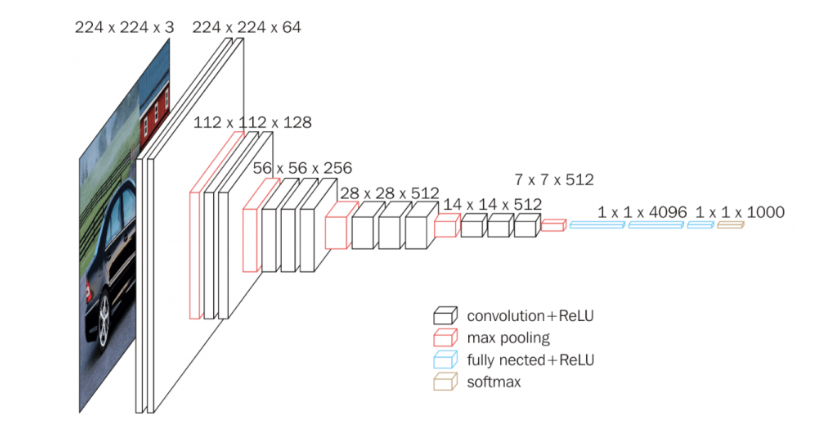

In [22]:
Image("/content/drive/MyDrive/자이/build/vgg/vgg_architecture.png")

- 3x3 conv x2 (channel : 64)
- 3x3 conv x2 (channel : 128)
- 3x3 conv x3 (channel : 256)
- 3x3 conv x3 (channel : 512)
- 3x3 conv x3 (channel : 512)
- fc layer x 3 (4096,4096,1000)


#### 3x3 conv x 2

In [ ]:
def conv2_block(in_dim, out_dim):
    model = nn.Sequential(
    nn.Conv2d(in_dim,out_dim,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1),
    nn.MaxPool2d(2,2)
        )
    return model

#### 3x3 conv x 3

In [ ]:
def conv3_block(in_dim, out_dim):
    model = nn.Sequential(
    nn.Conv2d(in_dim,out_dim,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2)
        )
    return model

### Modeling VGG

In [ ]:
class vgg(nn.Module):
    def __init__(self, dim, num_classes=10):
        super(vgg,self).__init__()
        self.feature = nn.Sequential(
            conv2_block(3,dim), #64
            conv2_block(dim,2*dim), #128
            conv3_block(2*dim,4*dim), # 256
            conv3_block(4*dim,8*dim), # 512
            conv3_block(8*dim,8*dim) # 512
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*dim*1*1, 4096),
            # MaxPool이 5번 진행되었으므로 2^5만큼 이미지 가로 세로가 줄어듬.
            # 사용할 데이터셋은 CIFAR10이고, 데이터셋의 이미지 가로세로는 32x32이므로 1*1을 함.
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096,1000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1000,num_classes)
        )

    def forward(self,x):
        x = self.feature(x)
        #print("x.shape",x.shape)
        x = x.view(x.size(0),-1)
        #print("x.size(0)",x.size(0))
        #print("x.shape",x.shape)
        x = self.fc_layer(x)
        return x

In [ ]:
batch_size = 32
learning_rate = 0.001
num_epoch = 50

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "mps"
model = vgg(dim=64).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

### Dataset Loader

In [ ]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)
train = datasets.CIFAR10(root = "../data",train=True,transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True)
test = datasets.CIFAR10(root = "../data",train=False,transform=transform,download=True)
test_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### explore dataset

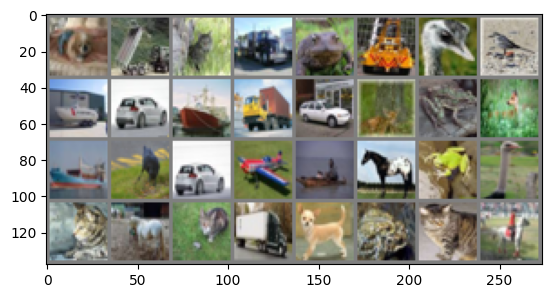

  dog truck   cat truck  frog truck  bird  bird  ship   car  ship truck   car  deer  frog  deer  ship  bird   car plane  ship horse  frog  bird   cat horse   cat truck   dog  frog   cat horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))


print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Train

In [ ]:
import time

start_time = time.time()

loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()

    if i % 10 == 0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

end_time = time.time()

total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")


tensor(2.3113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3024, device='cuda:0', grad_fn=<NllLossBackward0>)
Total execution time: 1813.0527892112732 seconds


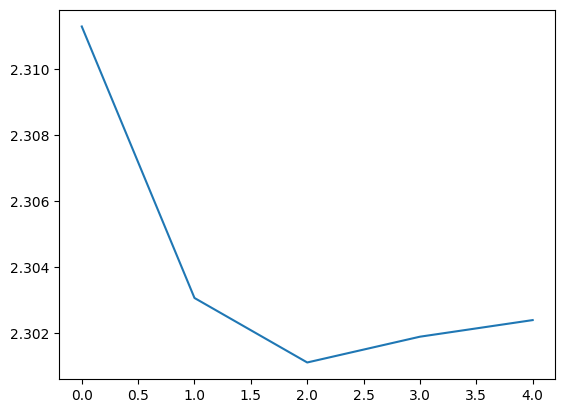

In [ ]:
plt.plot(loss_arr)
plt.show()

In [ ]:
correct = 0
total = 0

model.eval()

with torch.no_grad():
    for image,label in test_loader:

        x = image.to(device)
        y= label.to(device)

        output = model.forward(x)
        _,output_index = torch.max(output,1)


        total += label.size(0)
        correct += (output_index == y).sum().float()

    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 10.0%
